<a href="https://colab.research.google.com/github/ferjorosa/learn-fastai/blob/main/basic_mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to simply put my notes and examples of the MNIST example of Chapter 4 from the Fast AI book

In [1]:
#hide (Google Colab)
!pip install fastai --upgrade -q
import fastai
print(fastai.__version__)

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
2.5.3
     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.5 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 303 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [5]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [8]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [12]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

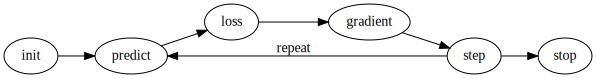

In [9]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [10]:
train_x =torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([0] * len(stacked_threes) + [1] *len(stacked_sevens)).unsqueeze(1)
(train_x.shape, train_y.shape)

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [13]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1,28*28)
valid_y = tensor([0] * len(valid_3_tens) + [1] * len(valid_7_tens)).unsqueeze(1)
(valid_x.shape, valid_y.shape)

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [19]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def linear3(x, w): return x@w + intercept
  
def predict(x, w):
  predictions = model(x, w)
  return torch.where(predictions > 0.5, 1, 0)

def validate(valid_x, w, valid_y):
  binary_preds = predict(valid_x, w)
  return (binary_preds == valid_y).count_nonzero() / valid_y.shape[0]

def epoch1(x, y, w, valid_x, valid_y, prt=True):
  pred = model(x, w)
  loss = mnist_loss(pred, y)
  loss.backward()
  if prt: print("Loss: " + str(loss))
  accuracy = validate(valid_x, w, valid_y)
  if prt: print("Validation accuracy: " + str(accuracy))
  w.data -= w.grad.data * lr

w = init_params((784, 1))
lr = 1e-3
model = linear3
weights = init_params((28*28,1))
intercept = init_params(1)

In [20]:
epoch1(train_x, train_y, w, valid_x, valid_y)

Loss: tensor(0.4925, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.5020)


In [ ]:
n_epochs = 1000
for i in range (1, n_epochs):
  epoch1(train_x, train_y, w, valid_x, valid_y)

**Stochastic gradient descent**

In [28]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(train_x, train_y))

In [37]:
train_dl = DataLoader(train_dset, batch_size=256)
xb, yb = first(train_dl)
print(xb.shape, yb.shape)

valid_dl = DataLoader(valid_dset, batch_size=256)
xb, yb = first(valid_dl)
print(xb.shape, yb.shape)

torch.Size([512, 784]) torch.Size([512, 1])
torch.Size([512, 784]) torch.Size([512, 1])


In [ ]:
model = linear3
weights = init_params((28*28,1))
intercept = init_params(1)
params = weights, intercept
lr = 1e-3

# This previously worked with the whole dataset, so no problem with batches
def calc_grad(xb, yb, w, prt=True):
  pred = model(xb, w)
  loss = mnist_loss(pred, yb)
  loss.backward()
  if prt: print("Loss: " + str(loss))

def epoch_batch(train_dl, params, valid_dl):
  for xb, yb in train_dl: # Iterates over batches, not individual instances
    calc_grad(xb, yb, w)
    for p in params:
      p.data = -p.grad * lr
      p.grad.zero_() # See page 172, last paragraph

In [38]:
# Small example just to see what was happening under the hood
# xb and yb are now batches, not individual data instances
#
# l = []
# for xb, yb in train_dl:
#   l.append(xb)
# len(l)

25